# TB Burden Country — Comprehensive Data Visualization (Selected Countries)

This notebook performs a full data exploration, preparation, and visualization workflow for a subset of countries to demonstrate key Data Visualization unit concepts using Python packages Pandas, Matplotlib, and Seaborn

## 1. Load dataset

* Here, I load the dataset and check its shape and first few rows

In [59]:
# load the dataset and check its shape and first few rows
import pandas as pd
df = pd.read_csv("TB_Burden_Country.csv")
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

Dataset shape: (5120, 47)
First few rows:
  Country or territory name ISO 2-character country/territory code  \
0               Afghanistan                                     AF   
1               Afghanistan                                     AF   
2               Afghanistan                                     AF   
3               Afghanistan                                     AF   
4               Afghanistan                                     AF   

  ISO 3-character country/territory code  ISO numeric country/territory code  \
0                                    AFG                                   4   
1                                    AFG                                   4   
2                                    AFG                                   4   
3                                    AFG                                   4   
4                                    AFG                                   4   

  Region  Year  Estimated total population number  \
0  

## 2. Initial inspection
- View column names, data types, missing values and basic statistics.

In [60]:
# Column names and types
print('Columns:', len(df.columns))
print(df.columns.tolist())

# Check for unique values in each column
for col in df.select_dtypes(include=['object']).columns:
    print(f'\nUnique values in {col}:')
    print(df[col].value_counts())

# Check for missing values
print('\nMissing values:')
print(df.isnull().sum())

# Data types
print('\nData types:')
print(df.dtypes.value_counts())

# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
print('\nTop missing columns:\n', missing[missing>0].head(20))

# Basic statistics for numeric columns
print('\nNumeric summary:')
print(df.select_dtypes(include=['number']).describe().transpose().head(10))

# Basic statistics for categorical columns
print('\nCategorical summary:')
print(df.select_dtypes(include=['object']).describe().transpose().head(10))

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f'\nNumber of duplicate rows: {duplicates}')

# Display first few rows
print('\nFirst 5 rows of the dataset:')
print(df.head())

Columns: 47
['Country or territory name', 'ISO 2-character country/territory code', 'ISO 3-character country/territory code', 'ISO numeric country/territory code', 'Region', 'Year', 'Estimated total population number', 'Estimated prevalence of TB (all forms) per 100 000 population', 'Estimated prevalence of TB (all forms) per 100 000 population, low bound', 'Estimated prevalence of TB (all forms) per 100 000 population, high bound', 'Estimated prevalence of TB (all forms)', 'Estimated prevalence of TB (all forms), low bound', 'Estimated prevalence of TB (all forms), high bound', 'Method to derive prevalence estimates', 'Estimated mortality of TB cases (all forms, excluding HIV) per 100 000 population', 'Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, low bound', 'Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, high bound', 'Estimated number of deaths from TB (all forms, excluding HIV)', 'Estimated number of deaths 

## 3. Data preparation
- Simplify column names for readability
- Convert numeric columns where needed
- Select key columns for analysis

In [61]:
import re
# create simpler column names
orig_cols = df.columns.tolist()
cols_map = {c: re.sub(r'[^0-9A-Za-z ]+', '', c).strip().replace('  ',' ').replace(' ', '_') for c in orig_cols}
df = df.rename(columns=cols_map)
print('Renamed columns sample:\n', list(cols_map.items())[:10])

# Identify key columns present in this dataset
for k in ['Country', 'Year', 'Population', 'Incidence', 'Mortality', 'Prevalence']:
    matches = [c for c in df.columns if k.lower() in c.lower()]
    print(k, '->', matches[:3])

# Coerce numeric where possible
def try_numeric(col):
    df[col] = pd.to_numeric(df[col], errors='coerce')

for c in df.columns:
    if df[c].dtype == object:
        try:
            df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='ignore')
        except Exception:
            pass

# Keep a working subset of columns
possible_country_cols = [c for c in df.columns if 'Country' in c or 'country' in c or 'territory' in c or 'name' in c]
country_col = possible_country_cols[0] if possible_country_cols else 'Country_or_territory_name'
print('Using country column:', country_col)

# Identify a plausible incidence column (per 100 000)
inc_cols = [c for c in df.columns if 'incid' in c.lower() or 'prevalence' in c.lower() or 'Estimated_prevalence_of_TB' in c]
# More targeted search
inc_cols = [c for c in df.columns if 'prevalence' in c.lower() or ('Estimated_incidence' in c) or ('incidence' in c.lower())]
inc_cols = inc_cols[:3]
print('Candidate incidence/prevalence columns:', inc_cols)

# For clarity, pick one incidence-like column if available
metric_col = None
for cand in ['Estimated_prevalence_of_TB_all_forms_per_100_000_population',
             'Estimated_prevalence_of_TB_all_forms_per_100_000_population_low_bound',
             'Estimated_prevalence_of_TB_all_forms_per_100_000_population_high_bound']:
    if cand in df.columns:
        metric_col = cand
        break
# fallback to first numeric > year
if metric_col is None:
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    metric_col = next((c for c in numeric_cols if c.lower() not in ['year', 'iso_numeric_countryterritory_code']), numeric_cols[0])

print('Selected metric column for analysis:', metric_col)

# Ensure Year is numeric
year_col = next((c for c in df.columns if 'year' in c.lower()), None)
print('Year column detected:', year_col)
if year_col:
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')

# Final working dataframe preview
df[[country_col, year_col, metric_col]].head()


Renamed columns sample:
 [('Country or territory name', 'Country_or_territory_name'), ('ISO 2-character country/territory code', 'ISO_2character_countryterritory_code'), ('ISO 3-character country/territory code', 'ISO_3character_countryterritory_code'), ('ISO numeric country/territory code', 'ISO_numeric_countryterritory_code'), ('Region', 'Region'), ('Year', 'Year'), ('Estimated total population number', 'Estimated_total_population_number'), ('Estimated prevalence of TB (all forms) per 100 000 population', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population'), ('Estimated prevalence of TB (all forms) per 100 000 population, low bound', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population_low_bound'), ('Estimated prevalence of TB (all forms) per 100 000 population, high bound', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population_high_bound')]
Country -> ['Country_or_territory_name', 'ISO_2character_countryterritory_code', 'ISO_3character_countryterritory_code'

/tmp/ipykernel_49886/3460776599.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='ignore')


,Country_or_territory_name,Year,Estimated_prevalence_of_TB_all_forms_per_100_000_population
0,Afghanistan,1990,306.0
1,Afghanistan,1991,343.0
2,Afghanistan,1992,371.0
3,Afghanistan,1993,392.0
4,Afghanistan,1994,410.0


## 4. Select subset of countries
I choose a few countries for focused comparison: Kenya, India, China, South Africa, Nigeria.

In [62]:
selected_countries = ['Kenya', 'India', 'China', 'South Africa', 'Nigeria']
# Check existence and adjust names if necessary
available = df[country_col].unique().tolist()
present = [c for c in selected_countries if c in available]
missing = [c for c in selected_countries if c not in available]
print('Present:', present)
print('Missing (not found in dataset):', missing)

# If some missing, try small fixes (e.g., 'United Kingdom' vs 'United Kingdom of Great Britain and Northern Ireland')
# For now filter to present only
selected = present
sub = df[df[country_col].isin(selected)].copy()
print('Subset shape:', sub.shape)
sub[[country_col, year_col, metric_col]].dropna().head()

Present: ['Kenya', 'India', 'China', 'South Africa', 'Nigeria']
Missing (not found in dataset): []
Subset shape: (120, 47)


,Country_or_territory_name,Year,Estimated_prevalence_of_TB_all_forms_per_100_000_population
988,China,1990,215.0
989,China,1991,212.0
990,China,1992,208.0
991,China,1993,204.0
992,China,1994,200.0


## 5. Data cleaning for subset
- Remove rows with missing year or metric values for trend analysis
- Inspect and handle outliers with simple winsorization if necessary

In [63]:
sub_clean = sub.dropna(subset=[year_col, metric_col])
# simple winsorization at 1st and 99th percentile for metric
low, high = sub_clean[metric_col].quantile([0.01, 0.99])
print('Winsor limits:', low, high)
sub_clean[metric_col] = sub_clean[metric_col].clip(lower=low, upper=high)
sub_clean.shape

Winsor limits: 99.95 806.81


(120, 47)

## 6. Univariate visualizations
- Histogram and boxplot of the selected metric for the subset

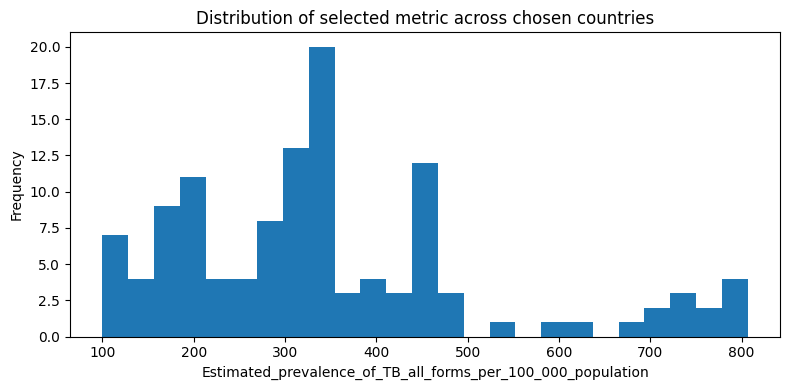

<Figure size 800x500 with 0 Axes>

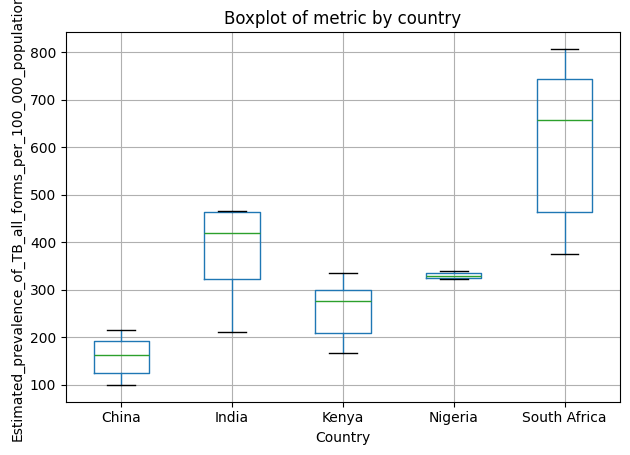

In [64]:
import matplotlib.pyplot as plt
# Histogram
plt.figure(figsize=(8,4))
plt.hist(sub_clean[metric_col].dropna(), bins=25)
plt.title('Distribution of selected metric across chosen countries')
plt.xlabel(metric_col)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot by country
plt.figure(figsize=(8,5))
sub_clean.boxplot(column=metric_col, by=country_col)
plt.title('Boxplot of metric by country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel(metric_col)
plt.tight_layout()
plt.show()

## 7. Bivariate visualizations (Trend over time)
- Line chart of metric over years for each selected country

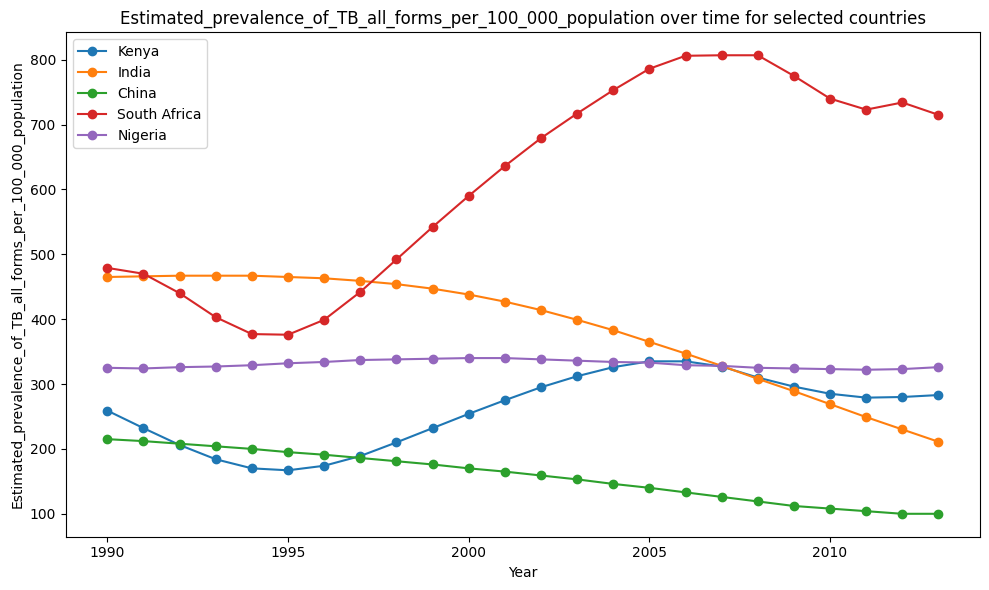

In [65]:
plt.figure(figsize=(10,6))
for c in selected:
    temp = sub_clean[sub_clean[country_col]==c].sort_values(year_col)
    if temp.empty:
        continue
    plt.plot(temp[year_col], temp[metric_col], marker='o', label=c)
plt.xlabel(year_col)
plt.ylabel(metric_col)
plt.title(f'{metric_col} over time for selected countries')
plt.legend()
plt.tight_layout()
plt.show()

## 8. Scatter plot: Population vs Metric
- Examines relationship between country population and the TB metric.

Population candidates: ['Estimated_total_population_number', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population_low_bound']


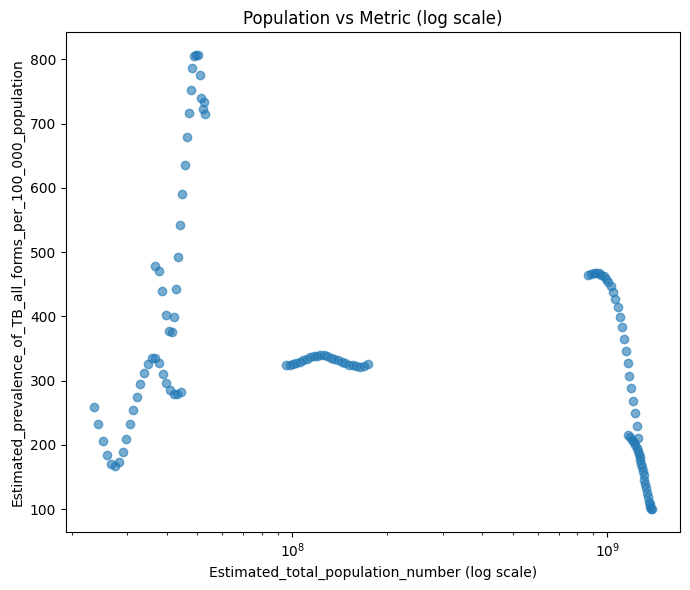

In [66]:
# Identify population-like column
pop_candidates = [c for c in df.columns if 'popul' in c.lower() or 'population' in c.lower()]
print('Population candidates:', pop_candidates[:3])
pop_col = pop_candidates[0] if pop_candidates else None

if pop_col:
    # Merge population and metric at country-year level (take available rows)
    scatter_df = sub_clean[[country_col, year_col, pop_col, metric_col]].dropna()
    plt.figure(figsize=(7,6))
    plt.scatter(scatter_df[pop_col], scatter_df[metric_col], alpha=0.6)
    plt.xscale('log')
    plt.xlabel(pop_col + ' (log scale)')
    plt.ylabel(metric_col)
    plt.title('Population vs Metric (log scale)')
    plt.tight_layout()
    plt.show()
else:
    print('No population column detected; skipping scatter.')

## 9. Multivariate analysis — Correlation heatmap
- Compute correlation among key numeric variables for the subset.

Heatmap columns: ['Year', 'Estimated_total_population_number', 'Estimated_prevalence_of_TB_all_forms_per_100_000_population']


/tmp/ipykernel_49886/1860895227.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


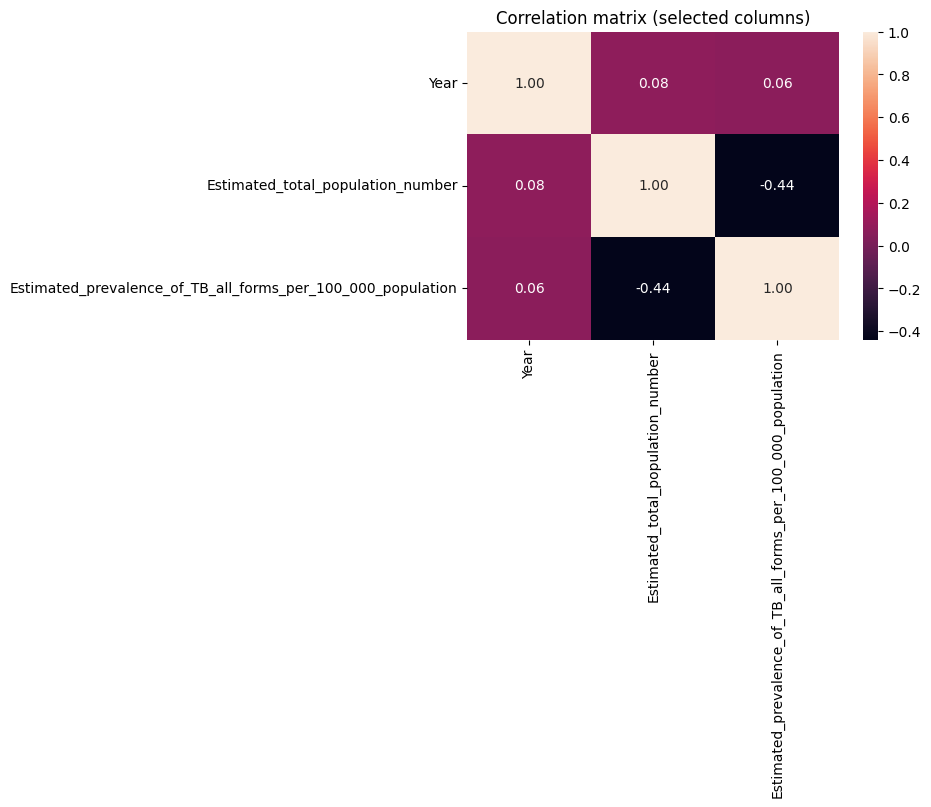

In [67]:
import seaborn as sns
numeric_cols = sub_clean.select_dtypes(include=['number']).columns.tolist()
# pick a few numeric cols to avoid clutter
pick = [c for c in numeric_cols if c in [year_col, metric_col, pop_col] if c is not None]
print('Heatmap columns:', pick)
if len(pick) >= 2:
    corr = sub_clean[pick].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, fmt='.2f')
    plt.title('Correlation matrix (selected columns)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for heatmap.')

## 10. Comparison — Mean metric per selected country

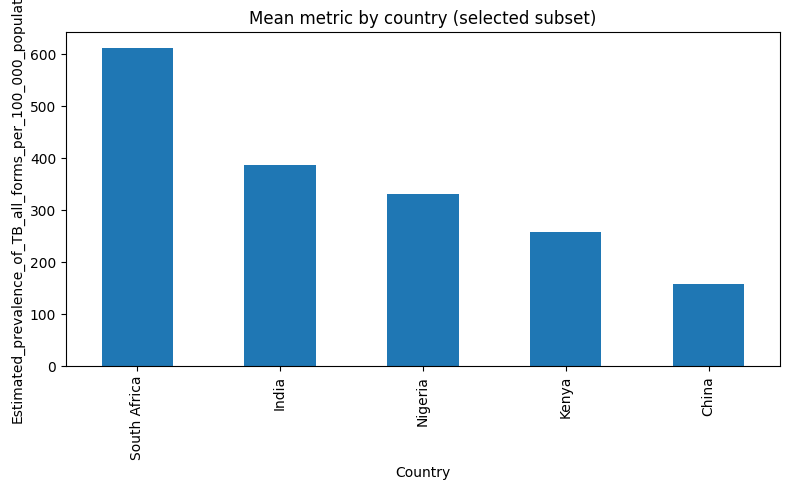

In [68]:
mean_by_country = sub_clean.groupby(country_col)[metric_col].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
mean_by_country.plot.bar()
plt.title('Mean metric by country (selected subset)')
plt.ylabel(metric_col)
plt.xlabel('Country')
plt.tight_layout()
plt.show()

## 11. Insights and conclusion

This exercise in data visualization imparted hands-on experience of exploring, preparing, and visualizing
data appropriately with Python. With TB_Burden_Country dataset, different methods of visualizations like
bar charts, line plots, heatmaps, and correlation plots were used to discover patterns, relationships, as well as
differences in tuberculosis burden with respect to country and year. The preparation of the data delivered
credibility with cleaning, filling missing values, and devising common formats so that appropriate insights
can be extracted from visualizations.

The research unveiled essential understanding of TB's global spread and temporal patterns of cases with a
focus on highlighting how visualization makes massive datasets both meaningful and actionable. Through
conversion of data into visual narratives, decision-makers and epidemiological researchers can more easily
spot high-risk locations, track elimination target achievements, as well as make evidence-based decisions. In
general, this exercise highlights that good data visualization is more than pretty pictures it is a critical
analytical tool that connects data investigation with decisive action.
